# Top 20 komend

In [ ]:
#klasyczny workflow
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# klasyczny workflow
data = load_iris()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# lda lub inna klasa from scratch
class my_LDA:
    def __init__(self): ...
    def fit(self, X, y): ...
    def fit_transform(self, X, y, n_components=2): ...
    def predict_proba(self, X): ...
    def predict(self, X): ...

# redukcja wymiarów:
lda = my_LDA()
X_reduced = lda.fit_transform(X_train, y_train, n_components=2)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train)
from sklearn.decomposition import PCA # lub
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# krzywa ROC i AUC
y_prob = lda.predict_proba(X_test)  
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

# generowanie danych syntetycznych
X[:, 0] = np.random.uniform(0, 4, 1000)
Y = np.sqrt(X[:, 0]) + np.random.normal(0, 0.1, 1000)
epsilon = np.random.normal(0, 0.1, 1000) 
Y = np.maximum(X[:, 0], 0) + np.maximum(X[:, 0] - 1, 0) + epsilon # lub

# grid search
clf = my_LDA()
param_grid = {
    'n_components': [1, 2, 3],
    'solver': ['svd', 'lsqr', 'eigen']
}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(clf, param_grid, cv=5)
grid.fit(X_train, y_train)

# rysowanie wariancji
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

# normalizacja danych
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# macierz pomyłek
y_pred = lda.predict(X_test)  
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

# svm
from sklearn.svm import SVC
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# krzywe predykcji
plt.plot(y, lda.predict(y.reshape(-1, 1)))
# predykcje vs dane
plt.scatter(X[:, 0], Y, alpha=0.4) 
plt.plot(X_test[:, 0], y_pred, color='r')
# wykres rozrzutu
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
# transformacja log
X[:, 0] = np.log1p(X[:, 0])

# wlasne generowanie danych
def generate_syntetic_dataset(n_samples, n_features, threshold):
        X = np.random.normal(loc=0, scale=1, size=(n_samples, n_features))
        X_squared_sum = np.sum(X**2, axis=1)
        y = np.where(X_squared_sum > threshold, 1, 0)
        return X, y

# Syntetic data generating

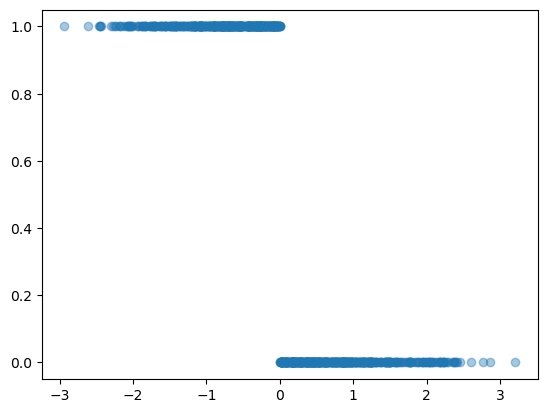

In [ ]:
# sqrt
X = np.zeros((1000, 50))
X[:, 0] = np.random.uniform(0, 4, 1000)
X[:, 1:] = np.random.normal(0, 1, (1000, 49))
epsilon = np.random.normal(0, 0.1, 1000)
Y = np.sqrt(X[:, 0]) + epsilon

# square
X = np.zeros((1000, 50))
X[:, 0] = np.random.uniform(0, 4, 1000)
X[:, 1:] = np.random.normal(0, 1, (1000, 49))
epsilon = np.random.normal(0, 0.1, 1000)
Y = X[:, 0]**2 + epsilon

# min + max
X = np.random.normal(0, 1, (1000, 50))
epsilon = np.random.normal(0, 0.1, 1000)
Y = np.maximum(X[:, 0], 0) + np.maximum(X[:, 0] - 1, 0) + epsilon

# sin
X = np.zeros((1000, 50))
X[:, 0] = np.random.uniform(0, 4, 1000)
X[:, 1:] = np.random.normal(0, 1, (1000, 49))
epsilon = np.random.normal(0, 0.1, 1000)
Y = np.sin(X[:, 0]) + epsilon

# I(X1 < 0)
X = np.random.normal(0, 1, (1000, 50))
epsilon = np.random.normal(0, 0.1, 1000)
Y = (X[:, 0] < 0).astype(int)  # I(X1 < 0)

plt.scatter(X[:, 0], Y, alpha=0.4, label="True")

# LDA

- LDA assumes a linear decision boundary, resulting from the equality of the covariance matrices in all classes.
- This makes LDA fast and stable, but it does not handle nonlinearly separable data well.
- With the fit_transform implementation, it handle with dimensionality reduction to min(n_components, number of classes - 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

class my_LDA:
    """
    - LDA assumes a linear decision boundary, resulting from the equality of the covariance matrices in all classes.
    - This makes LDA fast and stable, but it does not handle nonlinearly separable data well.
    - With the fit_transform implementation, it handle with dimensionality reduction to min(n_components, number of classes - 1)
    """
    def __init__(self):
        self.classes_ = None
        self.means_ = {}
        self.covariance_ = None
        self.priors_ = {}
        self.coef_ = {}
        self.intercepts_ = {}
        self.W_ = None  # matrix for dimensionality reduction
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        n_classes = len(self.classes_)
        pooled_cov = np.zeros((n_features, n_features))

        # computing means, priors and covariances for each class
        for cls in self.classes_:
            X_cls = X[y == cls]
            n_cls = X_cls.shape[0]
            mean_vec = np.mean(X_cls, axis=0)
            self.means_[cls] = mean_vec
            self.priors_[cls] = n_cls / n_samples

            # Pooled covariance
            if n_cls > 1:
                cov_matrix = np.cov(X_cls, rowvar=False, ddof=1)
            else: cov_matrix = np.zeros((n_features, n_features))
            pooled_cov += (n_cls-1) * cov_matrix

        pooled_cov /= (n_samples - n_classes)
        self.covariance_ = pooled_cov
        self.sigma_inv_ = np.linalg.pinv(pooled_cov) # (Moore-Penrose) pseudo-inverse of a matrix

        # computing coeficiants for each class
        for cls in self.classes_:
            delta_mu = self.means_[cls]
            self.coef_[cls] = self.sigma_inv_ @ delta_mu
            self.intercepts_[cls] = -0.5 * delta_mu @ self.sigma_inv_ @ delta_mu + np.log(self.priors_[cls])

    def fit_transform(self, X, y, n_components=2):
        """ transforming data for dimensionality reduction """
        self.fit(X, y)

        overall_mean = np.mean(X, axis=0)
        S_b = np.zeros((X.shape[1], X.shape[1]))

        for cls in self.classes_:
            n_cls = np.sum(y == cls)
            mean_vec = self.means_[cls].reshape(-1,1)
            overall_mean_vec = overall_mean.reshape(-1,1)
            S_b += n_cls * (mean_vec - overall_mean_vec) @ (mean_vec - overall_mean_vec).T
        
        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(self.covariance_) @ S_b)
        sorted_indices = np.argsort(eigvals)[::-1]
        self.W_ = eigvecs[:, sorted_indices[:n_components]]

        X_reduced = X @ self.W_
        return X_reduced

    def predict_proba(self, X):
        linear_predictors = {}
        for cls in self.classes_:
            linear_predictors[cls] = X @ self.coef_[cls] + self.intercepts_[cls]
        
        linear_predictors = np.array([linear_predictors[cls] for cls in self.classes_]).T
        exp_scores = np.exp(linear_predictors)
        prob_matrix = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # softmax
        return prob_matrix

    def predict(self, X):
        prob_matrix = self.predict_proba(X)
        return np.argmax(prob_matrix, axis=1)
    
    def get_params(self):
        print(f"LDA coefs: \n{self.coef_},\n intercept:\n {self.intercepts_},\n priors: \n{self.priors_},\n means: \n{self.means_}")

## chart 1: Dimensionality reduction with LDA

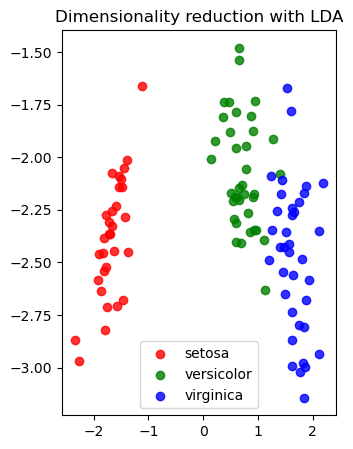

In [4]:
data = load_iris()
X = data.data
y = data.target
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# prediction
lda = my_LDA()
lda.fit(X_train,y_train)
probabilities = lda.predict_proba(X_test)

# dimensionality reduction
original_variance = np.sum(np.var(X_train, axis=0))
X_reduced = lda.fit_transform(X_train, y_train, n_components=2)
reduced_variance = np.sum(np.var(X_reduced, axis=0)) 
variance_retained = (reduced_variance / original_variance) * 100

# chart 1: Dimensionality reduction with LDA
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    plt.scatter(X_reduced[y_train == i, 0], X_reduced[y_train == i, 1], color=color, label=data.target_names[i], alpha=0.8)
plt.title('Dimensionality reduction with LDA')
plt.legend()

## Chart 2: Variance explianed with LDA components

([<matplotlib.axis.XTick at 0x1367c5760>,
 [Text(0, 0, 'LDA 1'), Text(1, 0, 'LDA 2')])

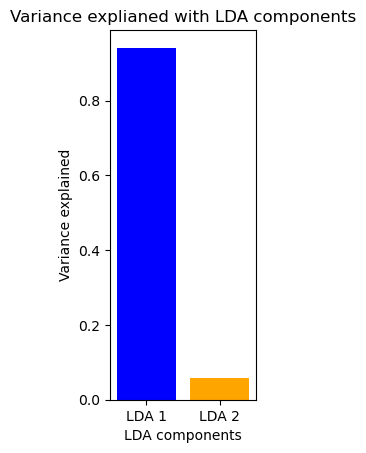

In [ ]:
plt.subplot(1, 3, 2)
variance_explained = np.var(X_reduced, axis=0) / np.sum(np.var(X_reduced, axis=0))
plt.bar(range(len(variance_explained)), variance_explained, color=['blue', 'orange'])
plt.title('Variance explianed with LDA components')
plt.xlabel('LDA components')
plt.ylabel('Variance explained')
plt.xticks([0, 1], ['LDA 1', 'LDA 2'])

## Chart 3: Comparison of variance before and after reduction

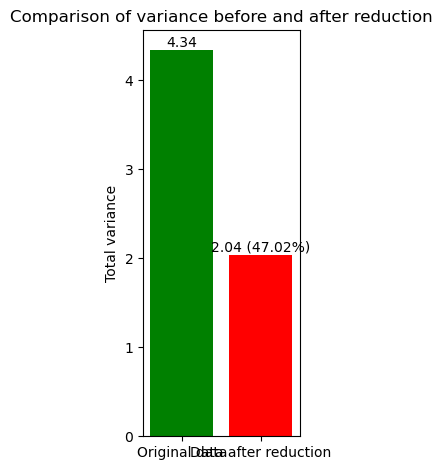

In [ ]:
plt.subplot(1, 3, 3)
plt.bar(['Original data', 'Data after reduction'], [original_variance, reduced_variance], color=['green', 'red'])
plt.title('Comparison of variance before and after reduction')
plt.ylabel('Total variance')
plt.text(0, original_variance, f'{original_variance:.2f}', ha='center', va='bottom')
plt.text(1, reduced_variance, f'{reduced_variance:.2f} ({variance_retained:.2f}%)', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# QDA

- Quadratic Discriminant Analysis (QDA) is a classification method based on Bayes' theorem and a normal (Gaussian) distribution of features in each class.
The main difference between QDA and LDA is that in QDA:
- Each class has its own covariance matrix, unlike in LDA, where the covariance matrix is common.
- The discriminant function is quadratic with respect to the features.

In [9]:
class my_QDA:
    """
    Quadratic Discriminant Analysis (QDA) is a classification method based on Bayes' theorem and a normal (Gaussian) distribution of features in each class.
    The main difference between QDA and LDA is that in QDA:
    - Each class has its own covariance matrix, unlike in LDA, where the covariance matrix is common.
    - The discriminant function is quadratic with respect to the features.
    """
    def __init__(self, epsilon=1e-6):
        self.epsilon_ = epsilon
        self.means_ = {}
        self.covariances_ = {}
        self.cov_inv_ = {}
        self.logdet_ = {}
        self.priors_ = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]

        for cls in self.classes_:
            X_cls = X[y == cls]
            n_cls = X_cls.shape[0]

            self.priors_[cls] = n_cls / n_samples
            self.means_[cls] = np.mean(X_cls, axis=0)

            cov_matrix = np.cov(X_cls, rowvar=False, ddof=1)
            cov_matrix += self.epsilon_ * np.eye(X.shape[1])
            self.covariances_[cls] = cov_matrix
            self.cov_inv_[cls] = np.linalg.pinv(cov_matrix)

            _, logdet = np.linalg.slogdet(cov_matrix)
            self.logdet_[cls] = logdet
        
    def predict_proba(self, X):
        discriminants = []

        for cls in self.classes_:
            mean_vec = self.means_[cls]
            cov_inv = self.cov_inv_[cls]
            logdet = self.logdet_[cls]
            prior = self.priors_[cls]

            diff = X - mean_vec
            quad_form = np.sum((diff @ cov_inv) * diff, axis=1)
            delta = -0.5*quad_form - 0.5*logdet + np.log(prior)
            discriminants.append(delta)
        
        discriminants = np.array(discriminants).T
        max_delta = np.max(discriminants, axis=1, keepdims=True)
        exp_discriminants = np.exp(discriminants - max_delta)
        prob_matrix = exp_discriminants / np.sum(exp_discriminants, axis=1, keepdims=True)
        return prob_matrix

    def predict(self, X):
        prob_matrix = self.predict_proba(X)
        return np.argmax(prob_matrix, axis=1)

## QDA predicted classes (test set)

Total samples: 105
Training samples: 105
Test samples: 45


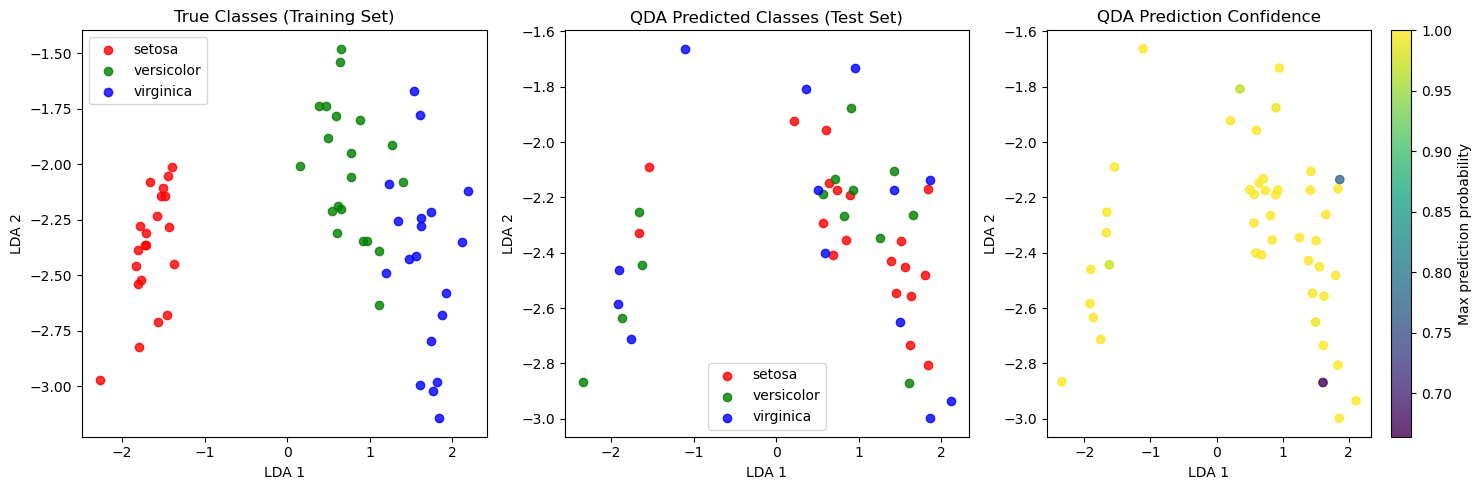

In [ ]:
data = load_iris()
X = data.data
y = data.target
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Prediction
test_points = X_reduced[-len(X_test):]  # Last 45 points
train_points = X_reduced[:-len(X_test)]  # First 60 points

# Prediction
qda = my_QDA()
qda.fit(X_train, y_train)  # Note: X_train should be the original 105 samples
probabilities = qda.predict_proba(X_test)
y_pred = qda.predict(X_test)

# Chart visualization
plt.figure(figsize=(15, 5))

# Subplot 1: True classes (training set)
plt.subplot(1, 2, 1)
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    plt.scatter(train_points[y_train[:-len(X_test)] == i, 0], 
               train_points[y_train[:-len(X_test)] == i, 1], 
               color=color, label=data.target_names[i], alpha=0.8)
plt.title('True Classes (Training Set)')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend()

# Subplot 2: QDA predicted classes (test set)
plt.subplot(1, 3, 2)
for i, color in enumerate(colors):
    mask = (y_pred == i)
    plt.scatter(test_points[mask, 0], 
               test_points[mask, 1],
               color=color, label=data.target_names[i], alpha=0.8)
plt.title('QDA Predicted Classes (Test Set)')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')
plt.legend()

# Subplot 3: QDA prediction probabilities (test set)
plt.subplot(1, 3, 3)
max_probs = np.max(probabilities, axis=1)
scatter = plt.scatter(test_points[:, 0], test_points[:, 1],
                     c=max_probs, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label='Max prediction probability')
plt.title('QDA Prediction Confidence')
plt.xlabel('LDA 1')
plt.ylabel('LDA 2')

plt.tight_layout()
plt.show()

# NB

Naive Bayes (NB) is a classification method that assumes:
- Independence of features within each class.
- Normal (Gaussian) distribution of features within each class.
- Added feature to operate with KDE estimator

In [22]:
from sklearn.metrics import accuracy_score
from scipy.stats import gaussian_kde
class my_NB:
    """
    Naive Bayes (NB) is a classification method that assumes:
    - Independence of features within each class.
    - Normal (Gaussian) distribution of features within each class.
    - Added feature to operate with KDE estimator
    """
    def __init__(self, method="gaussian"):
        self.means_ = {}
        self.variances_ = {}
        self.priors_ = {}
        self.classes_ = None
        self.method_ = method  # "gaussian", "kde"
        self.kde_ = {}  # For KDE method
    
    """ logarithms of pdf for selected method """
    def _log_gaussian_pdf(self, X, mu, var):
        log_prob = -0.5 * np.log(2 * np.pi * var) - 0.5 * ((X - mu) ** 2) / var
        return np.sum(log_prob, axis=1)
    
    def _log_kde_pdf(self, X, kde):
        log_prob = [np.log(kde[i](X[:,i])) for i in range(X.shape[1])]
        return np.sum(log_prob, axis=0)


    """ fit with data """
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]

        for cls in self.classes_:
            X_cls = X[y == cls]
            n_cls = X_cls.shape[0]
            self.priors_[cls] = n_cls / n_samples

            # parameters computing
            if self.method_ == "gaussian":
                self.means_[cls] = np.mean(X_cls, axis=0)
                self.variances_[cls] = np.var(X_cls, axis=0, ddof=1)
            if self.method_ == "kde":
                self.kde_[cls] = [gaussian_kde(X_cls[:,j]) for j in range(X.shape[1])]

    def predict_proba(self, X):
        log_probs = []

        for cls in self.classes_:
            prior = np.log(self.priors_[cls])

            if self.method_ == "gaussian":
                mu = self.means_[cls]
                var = self.variances_[cls]
                log_prob = self._log_gaussian_pdf(X, mu, var) + prior
            if self.method_ == "kde":
                kde = self.kde_[cls]
                log_prob = self._log_kde_pdf(X, kde) + prior

            log_probs.append(log_prob)

        # numerical stability and softmax
        log_probs = np.array(log_probs).T
        max_log = np.max(log_probs, axis=1, keepdims=True)
        exp_log_probs = np.exp(log_probs - max_log)
        prob_matrix = exp_log_probs / np.sum(exp_log_probs, axis=1, keepdims=True)
        return prob_matrix
    
    def predict(self, X):
        prob_matrix = self.predict_proba(X)
        return np.argmax(prob_matrix, axis=1)
    
    def get_params(self):
        return {'means': self.means_, 'variances': self.variances_, 'priors': self.priors_}

## Accuracy of Different Naive Bayes Methods on Iri

Accuracy for gaussian: 0.9778
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Accuracy for kde: 0.9778


/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_6939/2968851969.py:24: RuntimeWarning: divide by zero encountered in log
  log_prob = [np.log(kde[i](X[:,i])) for i in range(X.shape[1])]


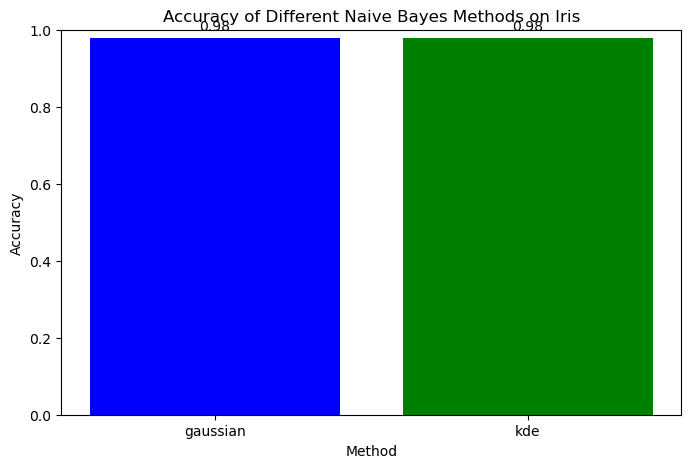

In [23]:
data = load_iris()
X = data.data
y = data.target
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Test for each method and plotting results
methods = ["gaussian", "kde"]
accuracies = []
for method in methods:
    nb = my_NB(method=method)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Accuracy for {method}: {acc:.4f}")
plt.figure(figsize=(8, 5))
plt.bar(methods, accuracies, color=["blue", "green", "orange"])
plt.title("Accuracy of Different Naive Bayes Methods on Iris")
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha="center")
plt.show()

# Logistic Regression

In [24]:
class my_LogisticRegression:
    def __init__(self, penalty=None, alpha=0.01, max_iter=1000, tol=1e-4):
        self.penalty = penalty
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.classes_ = None
        self.weights_ = None
    
    def _softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)
    
    def _loss(self, X, y, weights):
        m = X.shape[0]
        logits = X @ weights
        probs = self._softmax(logits)
        loss = -np.sum(np.log(probs[np.arange(m), y])) / m

        if self.penalty == "l2":
            loss += (self.alpha / 2) * np.sum(weights ** 2)
        if self.penalty == "l1":
            loss += (self.alpha) * np.sum(np.abs(weights))
        
        return loss

    def _gradient(self, X, y, weights):
        m = X.shape[0]
        logits = X @ weights
        probs = self._softmax(logits)
        one_hot_y = np.zeros_like(probs)
        one_hot_y[np.arange(m), y] = 1
        grad = X.T @ (probs - one_hot_y) / m

        if self.penalty == "l2":
            grad += self.alpha * weights
        elif self.penalty == "l1":
            grad += self.alpha * np.sign(weights)

        return grad
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        # adding bias column
        X = np.hstack([np.ones((X.shape[0],1)),X])
        self.weights_ = np.random.randn(X.shape[1], n_classes)

        for iteration in range(self.max_iter):
            grad = self._gradient(X, y, self.weights_)
            prev_weights = self.weights_.copy()
            self.weights_ -= self.alpha * grad

            if np.linalg.norm(self.weights_ - prev_weights, ord=1) < self.tol:
                print(f"Stopped after {iteration} iterations")
                break
    
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        logits = X @ self.weights_
        probs = self._softmax(logits)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def get_params(self):
        return {"weights": self.weights_, "penalty": self.penalty, "alpha": self.alpha}

## Different penalties results

In [25]:
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
penalties = [None, "l1", "l2"]
for penalty in penalties:
    model = my_LogisticRegression(penalty=penalty, alpha=0.01, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Penalty: {penalty}, Accuracy: {accuracy:.4f}")

Penalty: None, Accuracy: 0.9556
Penalty: l1, Accuracy: 0.8444
Penalty: l2, Accuracy: 0.9556


# LogRegCCD

In [28]:
from sklearn.metrics import (recall_score, precision_score, f1_score, 
                             balanced_accuracy_score, roc_auc_score, average_precision_score) 
from sklearn.preprocessing import StandardScaler

class my_LogRegCCD:
    def __init__(self, alpha=1.0, n_lambdas=100, eps=1e-3, tol=1e-4, max_iter=100, max_outer_iter=50):
        """
        alpha: parameter for mixing in the Elastic Net (1.0 means just the LASSO, 0.0 means L2)
        n_lambdas: number of lambda values in the path
        eps: lambda_min = eps * lambda_max
        tol: toleration for the convergence in coeficiant actualization
        max_iter: maximum number of iteration in CCD (inner loop) - coefficiant actualization
        max_outer_iter: IRLS maximum iteration number
        """
        self.alpha = alpha
        self.n_lambdas = n_lambdas
        self.eps = eps
        self.tol = tol
        self.max_iter = max_iter
        self.max_outer_iter = max_outer_iter
        self.lambdas = None
        self.coef_path = None
        self.intercept_path = None
        self.best_lambda = None
        self.best_coef = None
        self.best_intercept = None
        self.validation_scores = None

    def _soft_threshold(self, z, gamma):
        """ S(z,y) is the soft-thresholding operator with value: """
        if abs(z) > gamma and z>0: return z - gamma
        elif abs(z) > gamma and z<0: return z + gamma #I'm changing here so it'll fit formula (6) from the paper,
        else: return 0.0

    def _compute_lambda_max(self, X, y):
        """
        Computing lambda_max for which coefficiants equals 0 
        (claiming p_i = 0.5) 
        """
        N = X.shape[0]
        grad = np.abs(np.dot(X.T, (y - 0.5))) / N
        return np.max(grad) / self.alpha if self.alpha != 0 else np.max(grad)

    def fit(self, X_train, y_train):
        """
        Fits logistic regression model using CCD (with IRLS method)
        for the whole regularization path
        """
        N, p = X_train.shape 
        self.coef_path = []
        self.intercept_path = []
        
        lambda_max = self._compute_lambda_max(X_train, y_train) # computes max_lambda
        lambda_min = self.eps * lambda_max
        self.lambdas = np.logspace(np.log10(lambda_max), np.log10(lambda_min), self.n_lambdas) # generate lambdas for given n_lambdas, min and max

        # Warm start: coefficiants set to zero, intercept set to average logit fucntion
        beta = np.zeros(p)
        avg_y = np.mean(y_train)
        if (0 < avg_y < 1): #added change for avg_y ==1
            beta0 = np.log(avg_y / (1 - avg_y))
        elif (avg_y ==1):  
            beta0 = 1
        else: beta0 = 0
        
        # FOR EACH lambda we fit the model
        for lam in self.lambdas:
            # IRLS algorithm (outer loop)
            for outer_iter in range(self.max_outer_iter):
                eta = beta0 + np.dot(X_train, beta)
                eta = np.clip(eta, -500, 500) # protection for dividing by 0 
                p_vec = 1.0 / (1.0 + np.exp(-eta))
                p_vec = np.clip(p_vec, 1e-5, 1 - 1e-5) # protection for dividing by 0 
                w = p_vec * (1 - p_vec)

                # Calculating z - working response
                z = eta + (y_train - p_vec) / w
                # Coping beta to check covergance
                beta_old = beta.copy()
                beta0_old = beta0
                # Intercept actualization (without regularization)
                beta0 = np.sum(w * (z - np.dot(X_train, beta))) / np.sum(w) # where did you find this formula?

                # inner CCD loop – coefs actualization
                for iter_cd in range(self.max_iter):
                    beta_prev = beta.copy()
                    for j in range(p):
                        # residual wector for j-feature (without it itself) like in formula
                        r_j = z - beta0 - np.dot(X_train, beta) + X_train[:, j] * beta[j] #formula 5?
                        numerator = np.sum(w * X_train[:, j] * r_j)
                        denom = np.sum(w * X_train[:, j]**2) + lam * (1 - self.alpha) ##np.sum(w * X_train[:, j]**2) ??? the formula isn't (1+lambda(1-alfa)
                        beta[j] = self._soft_threshold(numerator, lam * self.alpha) / denom
                    if np.max(np.abs(beta - beta_prev)) < self.tol:
                        break

                # Checking IRLS convergance
                if np.max(np.abs(beta - beta_old)) < self.tol and abs(beta0 - beta0_old) < self.tol:
                    break

            self.coef_path.append(beta.copy())
            self.intercept_path.append(beta0)
        
        self.coef_path = np.array(self.coef_path) # shape: (n_lambdas, p)
        self.intercept_path = np.array(self.intercept_path)
    
    def predict_proba(self, X_test):
        """
        using best coefficient returns probabilities for X data
        """
        eta = self.best_intercept + np.dot(X_test, self.best_coef)
        return 1.0 / (1.0 + np.exp(-eta))
    
    def validate(self, X_valid, y_valid, measure='f1'):
        """
        Model scores on validation set for each lambda value 
        - choose best one with given measure
          - 'recall'
          - 'precision'
          - 'f1'
          - 'balanced_accuracy'
          - 'roc_auc'
          - 'average_precision'
        """
        scores = []
        for i, lam in enumerate(self.lambdas):
            beta = self.coef_path[i]
            beta0 = self.intercept_path[i]
            eta = beta0 + np.dot(X_valid, beta)
            eta = np.clip(eta, -500, 500) 
            p_pred = 1.0 / (1.0 + np.exp(-eta))
            y_pred = (p_pred >= 0.5).astype(int)
            if measure == 'recall': score = recall_score(y_valid, y_pred)
            elif measure == 'precision': score = precision_score(y_valid, y_pred)
            elif measure == 'f1': score = f1_score(y_valid, y_pred)
            elif measure == 'balanced_accuracy': score = balanced_accuracy_score(y_valid, y_pred)
            elif measure == 'roc_auc': score = roc_auc_score(y_valid, p_pred)
            elif measure == 'average_precision': score = average_precision_score(y_valid, p_pred)
            else: raise ValueError("Unsupported measure")
            scores.append(score)

        self.validation_scores = np.array(scores)
        best_index = np.argmax(self.validation_scores)
        self.best_lambda = self.lambdas[best_index]
        self.best_coef = self.coef_path[best_index]
        self.best_intercept = self.intercept_path[best_index]
        print(f"Optimal lambda: {self.best_lambda}, best {measure}: {self.validation_scores[best_index]}")
        return self.validation_scores # returns scores of given measure

    def plot(self, measure='f1'):
        """
        Plot of log10(lambda) vs given measure
        """
        if self.validation_scores is None:
            raise ValueError("Validation scores not computed. Run validate() first.")
        plt.figure(figsize=(8,6))
        plt.plot(np.log10(self.lambdas), self.validation_scores, marker='o')
        plt.xlabel('log10(lambda)')
        plt.ylabel(measure)
        plt.title(f'{measure} vs log10(lambda)')
        plt.grid(True)
        plt.show()

    def plot_coefficients(self):
        """
        Plot of coeficiants paths in lambda logarithm function
        """
        plt.figure(figsize=(8,6))
        for j in range(self.coef_path.shape[1]):
            plt.plot(np.log10(self.lambdas), self.coef_path[:, j], label=f'coef {j}')
        plt.xlabel('log10(lambda)')
        plt.ylabel('Value of coefficiants')
        plt.title('Coefficiant paths')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

## LogReg validation and prediction

Optimal lambda: 0.4845600009284007, best f1: 1.0


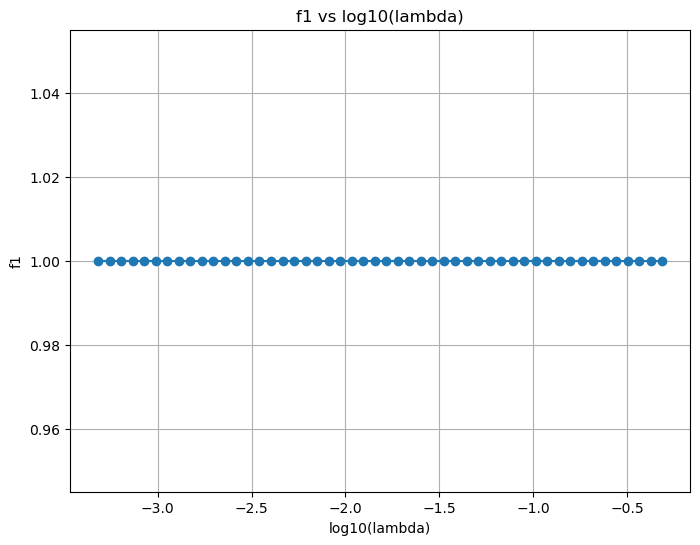

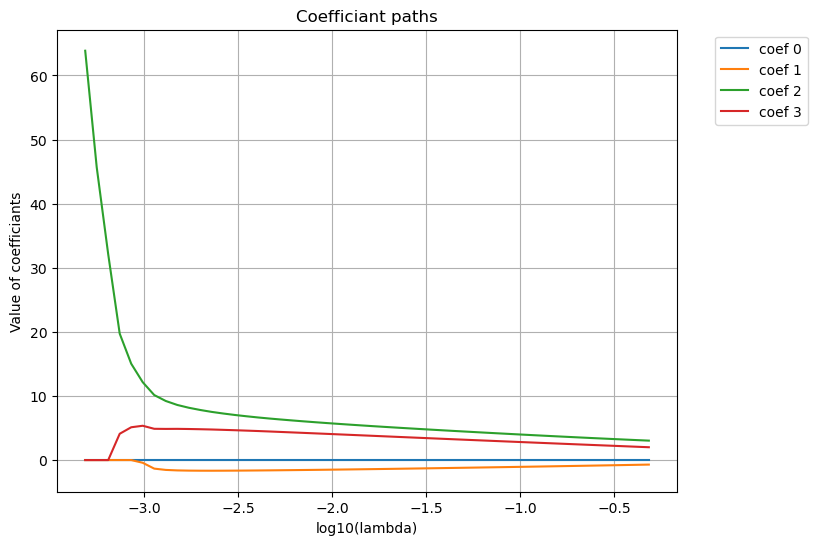

Final F1-score on validation set: 1.0000


In [33]:
data = load_iris()
X = data.data
y = data.target

# Filter to keep only classes 0 and 1
mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

# Encode labels (though they're already 0/1 after filtering)
le = LabelEncoder()
y = le.fit_transform(y)

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

model = my_LogRegCCD(alpha=1.0, n_lambdas=50, eps=1e-3, tol=1e-4) 
model.fit(X_train, y_train)
# search for optimal lambda value on the validation set (here f1 score)
model.validate(X_valid, y_valid, measure='f1')
# Plot for F1-score in relation to lambda values
model.plot(measure='f1')
model.plot_coefficients()
y_proba = model.predict_proba(X_valid)
y_pred = (y_proba >= 0.5).astype(int)
f1 = f1_score(y_valid, y_pred)
print(f"Final F1-score on validation set: {f1:.4f}") 

# Kernel Regression

In [34]:
def g(x):
    """ function to be estimated """
    return 4.26 * (np.exp(-x) - 4 * np.exp(-2*x) + 3 * np.exp(-3*x))

class NadarayaWatsonRegressor:
    def __init__(self, kernel="gaussian", bandwidth=0.5):
        """
        kernel: ['gaussian', 'epanechnikov', 'uniform']
        badwith: float (parametr wygladzania)
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.x_train = None
        self.y_train = None
    
    def _compute_kernel(self, u):
        """ computes kernel for vector u """
        if self.kernel == "gaussian":
            return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
        elif self.kernel == "epanechnikov":
            return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)
        elif self.kernel == "uniform":
            return np.where(np.abs(u) <= 1, 0.5, 0)
        else:
            raise ValueError("Nieznane jądro. Wybierz: 'gaussian', 'epanechnikov', 'uniform'.")
    
    def fit(self, x_train, y_train):
        self.x_train = np.array(x_train).reshape(-1)
        self.y_train = np.array(y_train).reshape(-1)
    
    def predict(self, x_test):
        x_test = np.array(x_test).reshape(-1)
        y_pred = np.zeros_like(x_test, dtype=float)

        for i, x in enumerate(x_test):
            u = (x - self.x_train) / self.bandwidth
            weights = self._compute_kernel(u)

            if np.sum(weights) == 0:
                y_pred[i] == np.mean(self.y_train)
            else:
                y_pred[i] = np.sum(weights * self.y_train) / np.sum(weights)
        
        return y_pred

## Naraday-Watson (Kernel regression) vs Splines

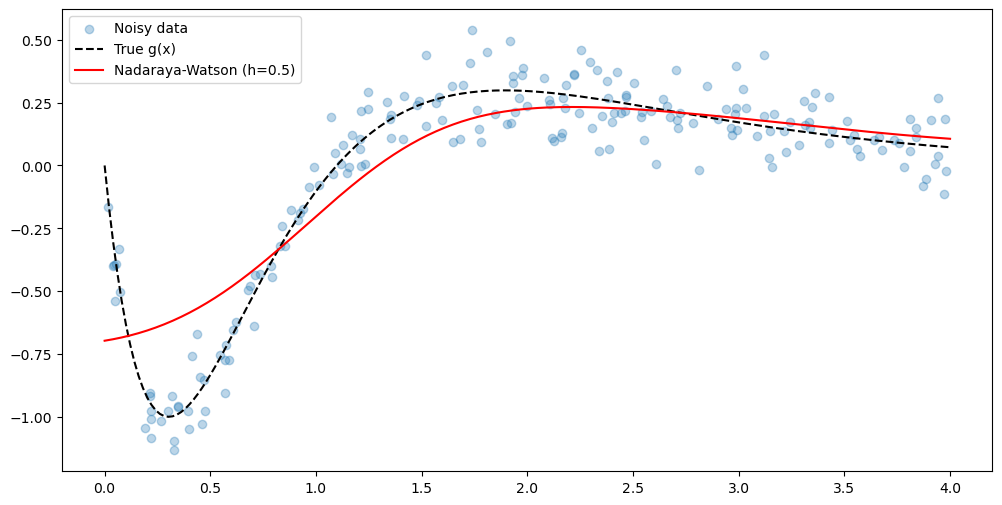

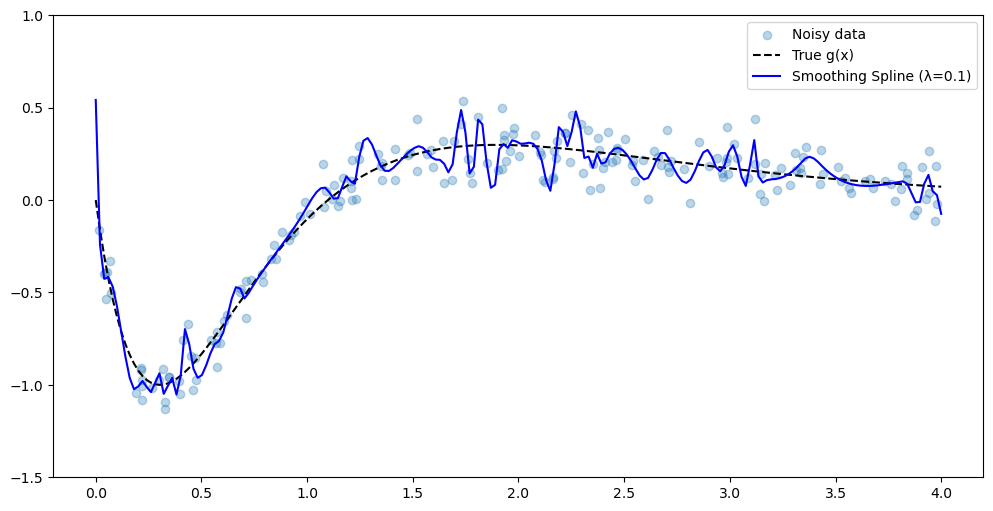

MSE g - spline:  -6.140950428208222e-06
MSE g - Nadaraya-Watson:  1.6224875052033476e-06


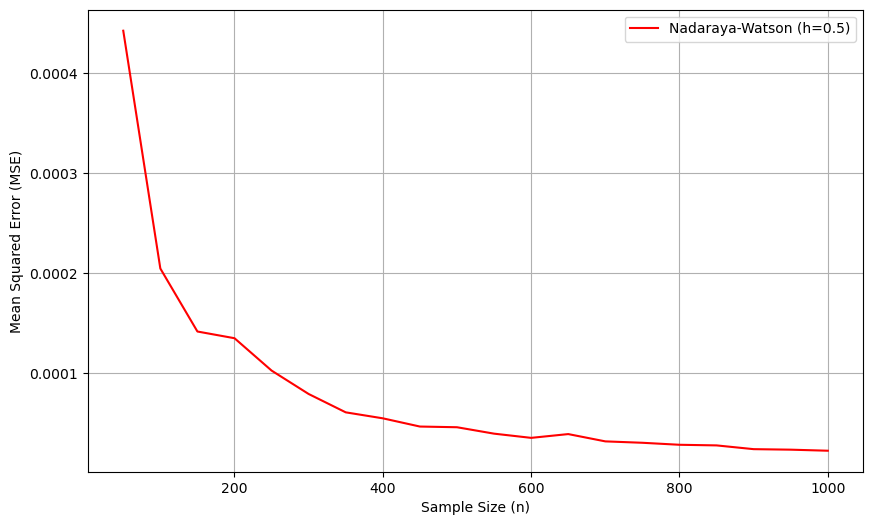

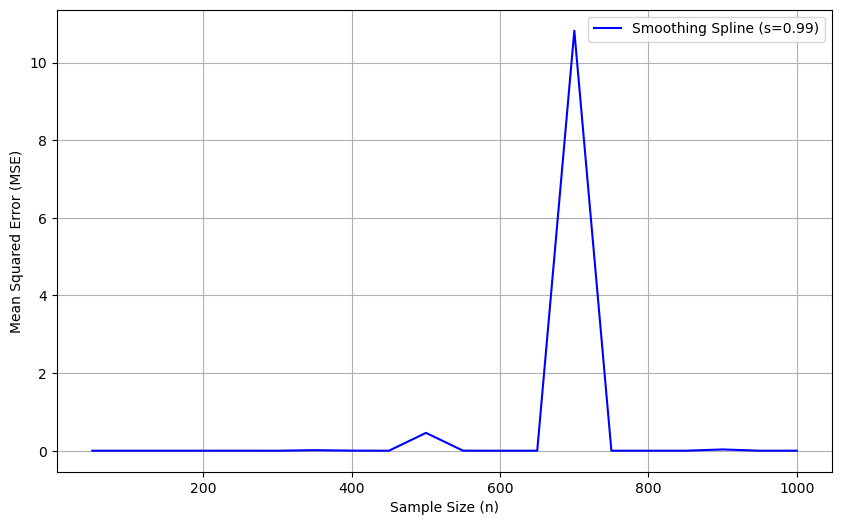

In [ ]:
from scipy.interpolate import UnivariateSpline

np.random.seed(320575)
n_samples = 200
x_train = np.random.uniform(0,4, n_samples)

epsilon = np.random.normal(0,0.1,n_samples)
y_train = g(x_train) + epsilon

nwr = NadarayaWatsonRegressor(kernel="gaussian", bandwidth=0.5)
nwr.fit(x_train, y_train)

x_test = np.linspace(0, 4, 200)
y_nw = nwr.predict(x_test)

sort_idx = np.argsort(x_train)
x_sorted = x_train[sort_idx]
y_sorted = y_train[sort_idx]
spline = UnivariateSpline(x_sorted, y_sorted, s=0.99)
y_spline = spline(x_test)

# Nadaraya-Watson Plot
plt.figure(figsize=(12, 6))
plt.scatter(x_train, y_train, alpha=0.3, label='Noisy data')
plt.plot(x_test, g(x_test), 'k--', label='True g(x)')
plt.plot(x_test, y_nw, 'r-', label='Nadaraya-Watson (h=0.5)')
plt.legend()
plt.show()

# Plot Smoothing spline
plt.figure(figsize=(12, 6))
plt.scatter(x_train, y_train, alpha=0.3, label='Noisy data')
plt.plot(x_test, g(x_test), 'k--', label='True g(x)')
plt.plot(x_test, y_spline, 'b-', label='Smoothing Spline (λ=0.1)')
plt.ylim(-1.5,1)
plt.legend()
plt.show()

print("MSE g - spline: ", np.mean(g(x_test)-y_spline) / n_samples)
print("MSE g - Nadaraya-Watson: ", np.mean(g(x_test)-y_nw)/ n_samples)

# MSE for different n samples
sample_sizes = np.arange(50, 1001, 50)  
mse_nw = []
mse_spline = []

for n in sample_sizes:
    x_train = np.random.uniform(0, 4, n)
    epsilon = np.random.normal(0, 0.1, n)
    y_train = g(x_train) + epsilon
    
    x_test = np.linspace(0, 4, 200)
    
    # Nadaraya-Watson
    nwr = NadarayaWatsonRegressor(kernel="gaussian", bandwidth=0.5)
    nwr.fit(x_train, y_train)
    y_nw = nwr.predict(x_test)
    
    # Smoothing Spline
    sort_idx = np.argsort(x_train)
    spline = UnivariateSpline(x_train[sort_idx], y_train[sort_idx], s=0.99)
    y_spline = spline(x_test)
    
    # Calculate MSE
    mse_nw.append(np.mean((g(x_test) - y_nw)**2) / n)
    mse_spline.append(np.mean((g(x_test) - y_spline)**2) / n)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, mse_nw, 'r-', label='Nadaraya-Watson (h=0.5)')
plt.xlabel('Sample Size (n)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, mse_spline, 'b-', label='Smoothing Spline (s=0.99)')
plt.xlabel('Sample Size (n)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Bagging

## Simple decision tree from scratch

In [39]:
class Node:
    def __init__(self, feature=None, threshold=None,
                 left=None, right=None, *, value=None):
        self.feature = feature   # indice
        self.threshold = threshold 
        self.left = left   # left sub-tree       
        self.right = right # right sub-tree
        self.value = value 

class my_DecisionTreeClassifier:
    def __init__(self, max_depth = 3):
        self.max_depth = max_depth
        self.root = None

    def gini(self, y):
        classes = set(y)
        impurity = 1
        for c in classes:
            p = sum(y == c) / len(y)
            impurity -= p**2
        return impurity
    
    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)
    
    def _build_tree(self, X, y, depth):
        num_samples_per_class = [np.sum(y == i) for i in np.unique(y)] # e.g [53, 45]
        predicted_class = np.argmax(num_samples_per_class)

        # stop condition
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return Node(value=predicted_class)
        
        feature, threshold, sets = self.best_split(X, y)
        if sets is None:
            return Node(value=predicted_class)

        left_idx, right_idx = sets
        left = self._build_tree(X[left_idx], y[left_idx], depth+1)
        right = self._build_tree(X[right_idx], y[right_idx], depth+1)
        return Node(feature, threshold, left, right)

    def best_split(self, X, y):
        m, n = X.shape
        best_feature, best_thresh, best_gain = None, None, 0
        best_sets = None
        parent_gini = self.gini(y)

        for feature in range(n):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = X[:, feature] > t
            if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                continue

            left_gini = self.gini(y[left_idx])
            right_gini = self.gini(y[right_idx])
            gain = parent_gini - (len(y[left_idx]) / len(y)) * left_gini - (len(y[right_idx]) / len(y)) * right_gini

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thresh = t
                best_sets = (left_idx, right_idx)

        return best_feature, best_thresh, best_sets
    
    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(x, self.root) for x in X])

## Plotting tree

My tree Accuracy: 0.6013986013986014
Parameter Impact Analysis:
   criterion splitter  max_depth  min_samples_split  n_nodes  train_acc  \
0      gini     best        NaN                  2       33   1.000000   
1      gini     best        NaN                 10       27   0.992958   
2      gini     best        NaN                 20       23   0.985915   
3      gini     best        3.0                  2       13   0.974178   
4      gini     best        3.0                 10       13   0.974178   

   test_acc  
0  0.895105  
1  0.895105  
2  0.909091  
3  0.902098  
4  0.902098  


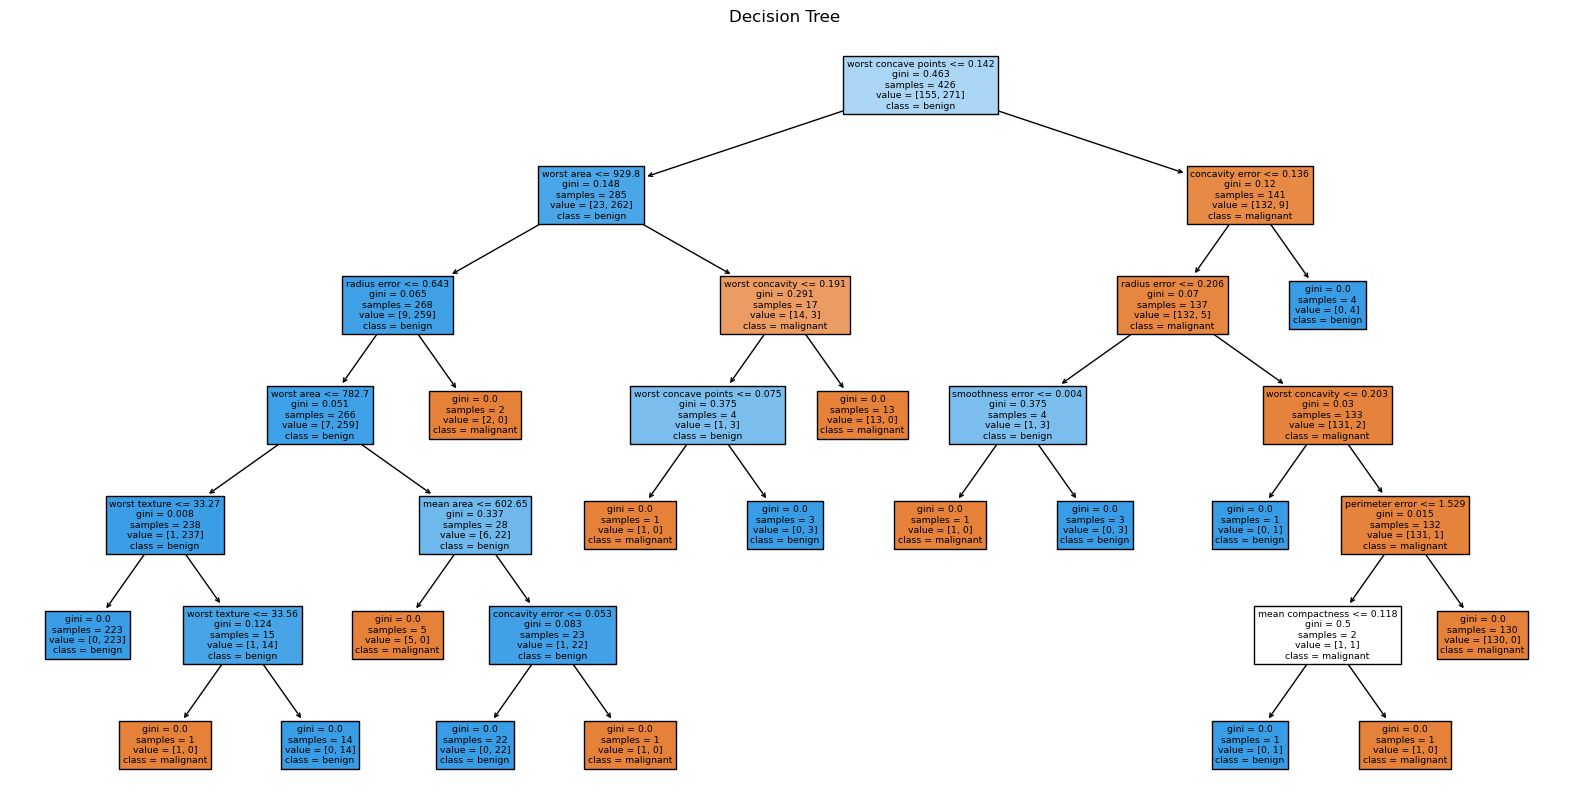


Cost-Complexity Pruning Results:
        alpha  n_nodes  train_acc  test_acc
8   0.009848       13   0.976526  0.909091
9   0.010556        7   0.960094  0.937063
10  0.016939        5   0.950704  0.937063
11  0.046833        3   0.924883  0.902098
12  0.324103        1   0.636150  0.601399


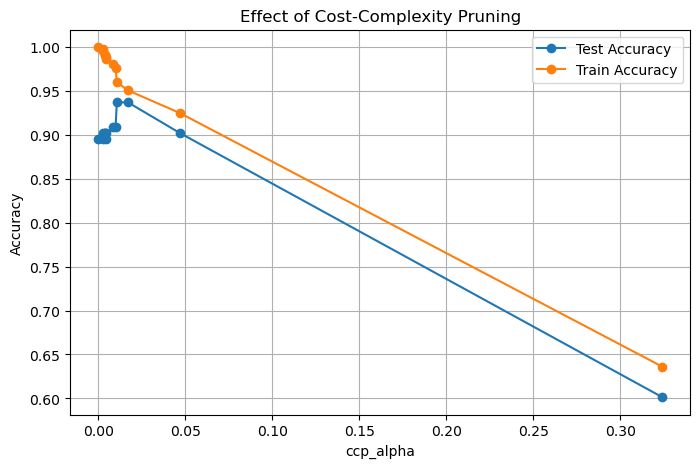

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import pandas as pd
from collections import Counter

# _____ Analyze self implementation _______
data = load_breast_cancer()
X,y = data.data, data.target
feature_names = data.feature_names
class_names = data.target_names
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

my_tree = my_DecisionTreeClassifier(max_depth=3)
my_tree.fit(X_train, y_train)
y_pred = my_tree.predict(X_test)

print("My tree Accuracy:", accuracy_score(y_test, y_pred))

# _____ Analyze sklearn implementation _______ 

# 1) Analyze parameter impact
criteria = ['gini', 'entropy']
splitters = ['best', 'random']
depths = [None, 3, 5]
min_samples = [2, 10, 20]

results = []
for crit in criteria:
    for split in splitters:
        for depth in depths:
            for min_split in min_samples:
                model = DecisionTreeClassifier(criterion=crit,
                               splitter=split,
                               max_depth=depth,
                               min_samples_split=min_split,
                               random_state=20)
                model.fit(X_train, y_train)
                results.append({
                    "criterion": crit,
                    "splitter": split,
                    "max_depth": depth,
                    "min_samples_split": min_split,
                    "n_nodes": model.tree_.node_count,
                    "train_acc": model.score(X_train, y_train),
                    "test_acc": model.score(X_test, y_test)
                })

df_results = pd.DataFrame(results)
print("Parameter Impact Analysis:\n", df_results.head())

# 2) Plot default tree
clf = DecisionTreeClassifier(random_state=20)
clf.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True,
          feature_names=feature_names,
          class_names=class_names)
plt.title("Decision Tree")
plt.show()

# 3) Cost-Cemplexity Pruning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

pruned_models = []
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(random_state=20, ccp_alpha=alpha)
    pruned_tree.fit(X_train, y_train)
    pruned_models.append({
        "alpha": alpha,
        "n_nodes": pruned_tree.tree_.node_count,
        "train_acc": pruned_tree.score(X_train, y_train),
        "test_acc": pruned_tree.score(X_test, y_test)
    })

df_pruning = pd.DataFrame(pruned_models)
print("\nCost-Complexity Pruning Results:\n", df_pruning.tail())

# Plot pruning effect
plt.figure(figsize=(8, 5))
plt.plot(df_pruning["alpha"], df_pruning["test_acc"], marker='o', label="Test Accuracy")
plt.plot(df_pruning["alpha"], df_pruning["train_acc"], marker='o', label="Train Accuracy")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Effect of Cost-Complexity Pruning")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data = load_breast_cancer()
X,y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

class My_BaggingClassifier:
    def __init__(self, base_estimator, n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.models = []
    
    def bootstrap_sample(self, X, y):
        """ returns generated boostrap sample """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]
    
    def _clone_estimator(self):
        """ returns new DecisionTree instance """
        return clone(self.base_estimator)

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            model = self._clone_estimator()
            model.fit(X_sample, y_sample)
            self.models.append(model)
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        final_predictions = [Counter(pred).most_common(1)[0][0] for pred in predictions.T]
        return final_predictions

In [38]:
bagging = My_BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Bagging accuracy:", acc)

Bagging accuracy: 0.958041958041958


# Adaboost

In [ ]:
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.base import clone
from collections import defaultdict
from scipy.stats import chi2

class MyAdaBoost:
    def __init__(self, base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=10):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.models = []
        self.betas = []

    def fit(self, X, y):
        n = X.shape[0]
        w = np.ones(n) / n # i. weights initialization

        # ii. iterations
        for k in range(self.n_estimators):
            #A build clf with weights w_i
            model = clone(self.base_estimator)
            model.fit(X, y, sample_weight=w)
            
            #B compute weitghed error 
            pred = model.predict(X)
            incorrect = (pred != y)
            epsilon = np.dot(w, incorrect)

            #C calculate Beta
            if epsilon == 0: beta=1e-10         # divide by 0 protection
            elif epsilon >= 0.5: continue       # weak classificators
            else: beta = epsilon / (1-epsilon)

            #D save clf and his weight
            self.models.append(model)
            self.betas.append(beta)

            # F. weights normalization
            w *= np.where(pred == y, beta, 1)
            w /= np.sum(w)
    
    def predict(self, X):
        if not self.models: 
            raise ValueError("Model has not been trained")
    
        all_prds = [model.predict(X) for model in self.models]
        final_prds = []

        for i in range(X.shape[0]):
            vote_count  = defaultdict(float)
            for k in range(len(self.models)):
                label = all_prds[k][i]
                vote_count[label] += np.log(1 / self.betas[k])
            
            # class with the biggest weighted sum log(1/beta)
            final_label = max(vote_count.items(), key=lambda x: x[1])[0]
            final_prds.append(final_label)
        
        return np.array(final_prds)

In [ ]:
def generate_syntetic_dataset(n_samples, n_features, threshold):
        X = np.random.normal(loc=0, scale=1, size=(n_samples, n_features))
        X_squared_sum = np.sum(X**2, axis=1)
        y = np.where(X_squared_sum > threshold, 1, 0)
        return X, y
    
    # Median of chi-squared distribution with 10 degrees of freedom
chi2_median = chi2.ppf(0.5, df=10)
X_train_syntetic, y_train_syntetic = generate_syntetic_dataset(n_samples = 2000, n_features = 10, threshold = chi2_median)
X_test_syntetic, y_test_syntetic = generate_syntetic_dataset(n_samples = 10000, n_features = 10, threshold = chi2_median)
data_syntetic = X_train_syntetic, y_train_syntetic, X_test_syntetic, y_test_syntetic 

#1) load datasets
wine_data = load_wine()
X_wine,y_wine = wine_data.data,wine_data.target
mask = (y_wine == 0) | (y_wine == 1) # keep 0|1
X_wine,y_wine = X_wine[mask], y_wine[mask]

ada = MyAdaBoost(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=20)
ada.fit(X_train_syntetic, X_test_syntetic)
y_pred_wine = ada.predict(X_wine)
acc_wine = accuracy_score(y_wine, y_pred_wine)

# Feature selection methods


___ Experiment for n=500, k=5, p=20
 __

 Dataset 1 - boruta - Boruta Results:
   Feature  Selected  Ranking
0       X1      True        1
1       X2      True        1
2       X3      True        1
3       X4      True        1
4       X5      True        1
5       X6     False        9
6       X7     False        2
7       X8     False       12
8       X9     False       11
9      X10     False        4
10     X11     False       14
11     X12     False       13
12     X13     False       10
13     X14     False        8
14     X15     False       14
15     X16     False        6
16     X17     False        6
17     X18     False        3
18     X19     False       16
19     X20     False        5


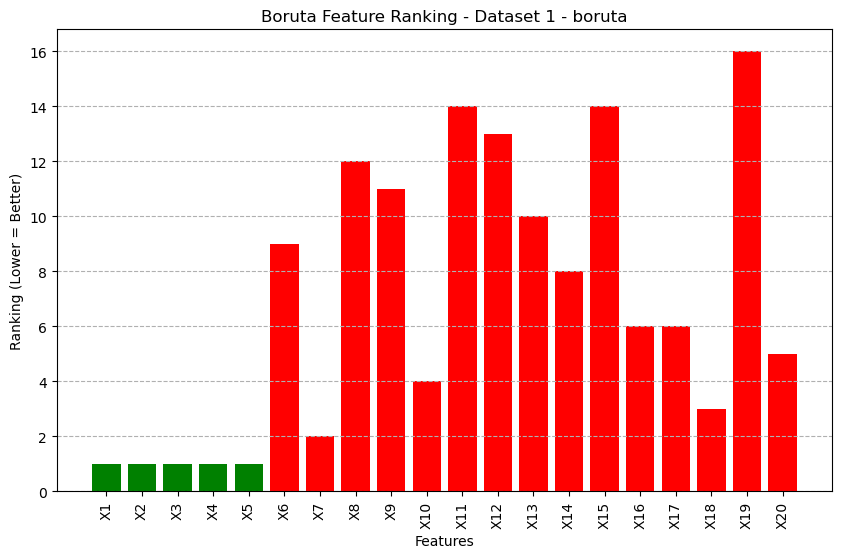


 Dataset 2 - boruto - Boruta Results:
   Feature  Selected  Ranking
0       X1      True        1
1       X2      True        1
2       X3      True        1
3       X4      True        1
4       X5      True        1
5       X6     False        5
6       X7     False       16
7       X8     False        4
8       X9     False       13
9      X10     False        8
10     X11     False       10
11     X12     False        8
12     X13     False        8
13     X14     False        3
14     X15     False       10
15     X16     False        5
16     X17     False       14
17     X18     False       12
18     X19     False        2
19     X20     False       15


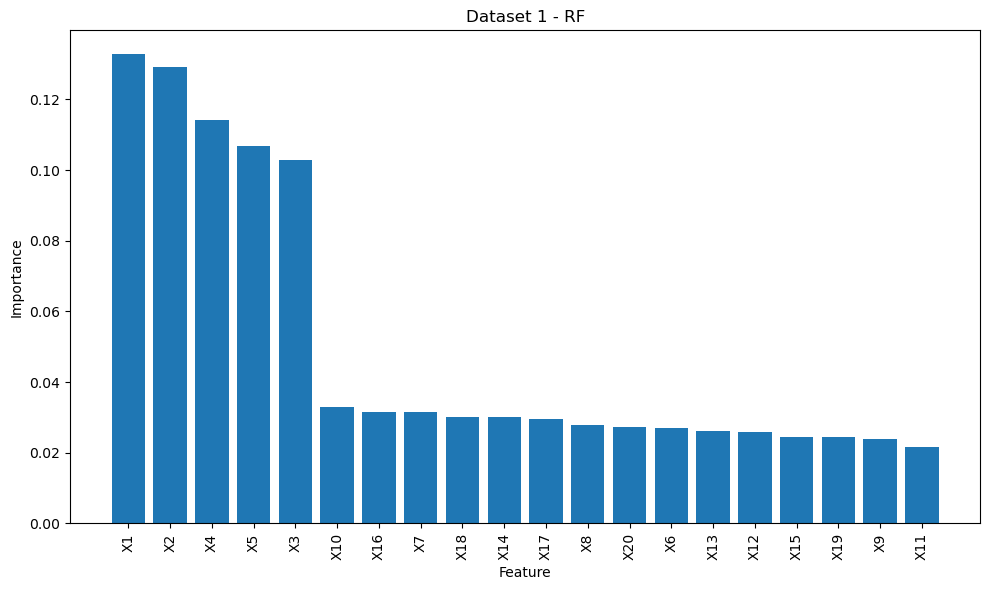


 Dataset 1 - Boruta Results:
   Feature  Selected  Ranking
0       X1      True        1
1       X2      True        1
2       X3      True        1
3       X4      True        1
4       X5      True        1
5       X6     False        9
6       X7     False        3
7       X8     False       10
8       X9     False        2
9      X10     False       14
10     X11     False        6
11     X12     False        6
12     X13     False        4
13     X14     False        8
14     X15     False       15
15     X16     False       11
16     X17     False        6
17     X18     False       12
18     X19     False        3
19     X20     False       14

 Dataset 2 - Boruta Results:
   Feature  Selected  Ranking
0       X1      True        1
1       X2      True        1
2       X3      True        1
3       X4      True        1
4       X5      True        1
5       X6     False        6
6       X7     False        4
7       X8     False        3
8       X9     False       14
9      X10

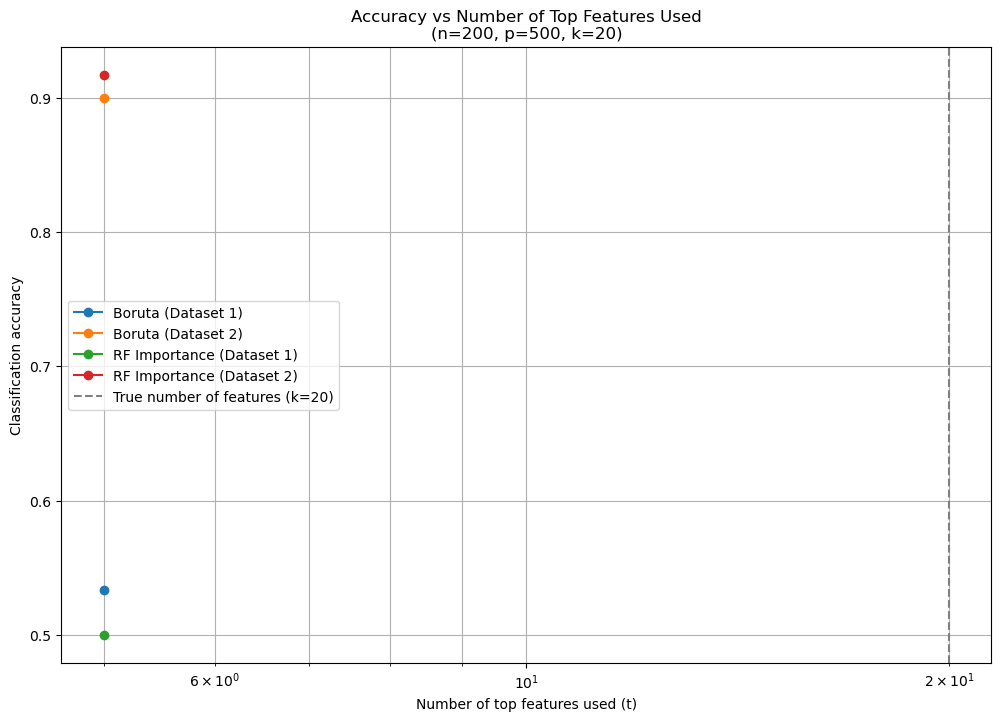

In [43]:
import numpy as np
import pandas as pd
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import chi2

def generate_dataset1(n, p, k):
    X = np.random.normal(0, 1, size=(n, p))
    chi2_median = chi2.ppf(0.5, df=k)

    # Calculate the sum of squares of the first k featrures for each sample
    sum_of_squares = np.sum(X[:, :k]**2, axis=1)
    y = (sum_of_squares > chi2_median).astype(int)
    return X, y

def generate_dataset2(n, p, k):
    X = np.random.normal(0, 1, size=(n, p))
    sum_abs = np.sum(np.abs(X[:, :k]), axis=1)
    y = (sum_abs > k).astype(int)
    return X, y

### --- Random Forest Feature Selection ---
def run_rf_importance(X, y, feature_names, title, k, plot=True):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    mdi_importances = rf.feature_importances_
    indices = np.argsort(mdi_importances)[::-1]

    if plot==True:
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(mdi_importances)), 
                mdi_importances[indices], align="center")
        plt.xticks(range(len(mdi_importances)), 
                [feature_names[i] for i in indices], rotation=90)
        plt.title(title)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()

    ranked_features = np.argsort(mdi_importances)[::-1] 
    return [idx for idx in ranked_features[:k]]

### --- Boruta Feature Selection ---
def run_boruta(X, y, feature_names, title, k=5, plot=True):
    rf = RandomForestClassifier(n_estimators=100, random_state=1, max_depth=5)

    boruta = BorutaPy(
        estimator=rf,
        n_estimators="auto",
        max_iter=50,
        random_state=1,
        verbose=0
    )

    boruta.fit(X, y)
    selected = boruta.support_
    ranked_features = boruta.ranking_
    print(f"\n {title} - Boruta Results:")
    print(pd.DataFrame({
        "Feature": feature_names,
        "Selected": selected,
        "Ranking": ranked_features,
    }))

    # Plot feature ranking
    if plot==True:
        plt.figure(figsize=(10, 6))
        plt.bar(feature_names, ranked_features, color=[('green' if s else 'red') for s in selected])
        plt.xticks(rotation=90)
        plt.title(f"Boruta Feature Ranking - {title}")
        plt.xlabel("Features")
        plt.ylabel("Ranking (Lower = Better)")
        plt.grid(axis='y', linestyle='--')
        plt.show()
    
    return np.argsort(ranked_features)[:k]


# _____ main _______

if __name__ == "__main__":
    # a) - b) Try different values of n, p and k. 
    n = [500]  # number of samples
    p = [20]    # total number of features
    k = [5]     # number of significant features

    for ni in n:
        for pi in p:
            for ki in k:
                print(f"\n___ Experiment for n={ni}, k={ki}, p={pi}\n __")
                X1, y1 = generate_dataset1(ni, pi, ki)
                X2, y2 = generate_dataset2(ni, pi, ki)

                feature_names = [f"X{i+1}" for i in range(pi)]
                _ = run_boruta(X1, y1, feature_names, "Dataset 1 - boruta", ki, plot=True)
                _ = run_boruta(X2, y2, feature_names, "Dataset 2 - boruto", ki, plot=False) # if show a plot then change to true
                _ = run_rf_importance(X1, y1, feature_names, "Dataset 1 - RF", ki, plot=True)
                _ = run_rf_importance(X2, y2, feature_names, "Dataset 2 - RF", ki, plot=False)

    # c) estimation on the probabilities of correct ordering L=25 experiments
    L = 4
    results_boruta_d1 = []
    results_boruta_d2 = []
    results_rf_d1 = []
    results_rf_d2 = []

    for ex in range(L):
        X1, y1 = generate_dataset1(n[0], p[0], k[0])
        X2, y2 = generate_dataset2(n[0], p[0], k[0])
        feature_names = [f"X{i+1}" for i in range(p[0])]

        # Run Boruta on Dataset 1 and Dataset 2
        boruta_ranking_d1 = run_boruta(X1, y1, feature_names, title="Dataset 1", k=k[0], plot=False)
        boruta_ranking_d2 = run_boruta(X2, y2, feature_names, title="Dataset 2", k=k[0], plot=False)
        
        # Run RF importance on Dataset 1 and Dataset 2
        rf_top_d1 = run_rf_importance(X1, y1, feature_names, title="Dataset 1", k=k[0], plot=False)
        rf_top_d2 = run_rf_importance(X2, y2, feature_names, title="Dataset 2", k=k[0], plot=False)
        
        correct_boruta_d1 = all(feat_idx < k[0] for feat_idx in boruta_ranking_d1)
        correct_boruta_d2 = all(feat_idx < k[0] for feat_idx in boruta_ranking_d1)
        correct_rf_d1 = all(feat_idx < k[0] for feat_idx in rf_top_d1)
        correct_rf_d2 = all(feat_idx < k[0] for feat_idx in rf_top_d1)

        # Store results
        results_boruta_d1.append(correct_boruta_d1)
        results_boruta_d2.append(correct_boruta_d2)
        results_rf_d1.append(rf_top_d1)
        results_rf_d2.append(rf_top_d2)

    prob_boruta_d1 = np.mean(results_boruta_d1)
    prob_boruta_d2 = np.mean(results_boruta_d2)
    prob_rf_d1 = np.mean(results_rf_d1)
    prob_rf_d2 = np.mean(results_rf_d2)

    print("\c) Probability of Correct Ordering (Top k features):")
    print(f"Boruta (Dataset 1): {prob_boruta_d1:.2%}")
    print(f"Boruta (Dataset 2): {prob_boruta_d2:.2%}")
    print(f"RF Importance (Dataset 1): {prob_rf_d1:.2%}")
    print(f"RF Importance (Dataset 2): {prob_rf_d2:.2%}")

    # d) Experiment with t - number of top-ranked features

    def get_boruta_features(X, y):
        rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
        boruta = BorutaPy(estimator=rf, n_estimators='auto', max_iter=50, random_state=1, verbose=0)
        boruta.fit(X, y)
        return np.argsort(boruta.ranking_)
    
    def get_rf_features(X, y):
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        return np.argsort(rf.feature_importances_)[::-1]

    def evaluate_accuracy(X_train, X_test, y_train, y_test, features, t_values):
        accuracies = []
        for t in t_values:
            selected = features[:t]
            rf = RandomForestClassifier(n_estimators=100, random_state=1)
            rf.fit(X_train[:, selected], y_train)
            y_pred = rf.predict(X_test[:, selected])
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)
        return accuracies
    
    n = 200
    p = 500
    k = 20
    t_values = [5]  # number of top features to test

    X1, y1 = generate_dataset1(n, p, k)
    X2, y2 = generate_dataset2(n, p, k)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

    boruta_features_d1 = get_boruta_features(X1_train, y1_train)
    boruta_features_d2 = get_boruta_features(X2_train, y2_train)
    rf_features_d1 = get_rf_features(X1_train, y1_train)
    rf_features_d2 = get_rf_features(X2_train, y2_train)

    acc_boruta_d1 = evaluate_accuracy(X1_train, X1_test, y1_train, y1_test, boruta_features_d1, t_values)
    acc_boruta_d2 = evaluate_accuracy(X2_train, X2_test, y2_train, y2_test, boruta_features_d2, t_values)
    acc_rf_d1 = evaluate_accuracy(X1_train, X1_test, y1_train, y1_test, rf_features_d1, t_values)
    acc_rf_d2 = evaluate_accuracy(X2_train, X2_test, y2_train, y2_test, rf_features_d2, t_values)

    plt.figure(figsize=(12, 8))
    plt.plot(t_values, acc_boruta_d1, 'o-', label='Boruta (Dataset 1)')
    plt.plot(t_values, acc_boruta_d2, 'o-', label='Boruta (Dataset 2)')
    plt.plot(t_values, acc_rf_d1, 'o-', label='RF Importance (Dataset 1)')
    plt.plot(t_values, acc_rf_d2, 'o-', label='RF Importance (Dataset 2)')
    plt.axvline(x=k, color='gray', linestyle='--', label='True number of features (k=20)')
    plt.xscale('log')
    plt.xlabel('Number of top features used (t)')
    plt.ylabel('Classification accuracy')
    plt.title('Accuracy vs Number of Top Features Used\n(n=200, p=500, k=20)')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()

# Multilabel processing

0.29411764705882354


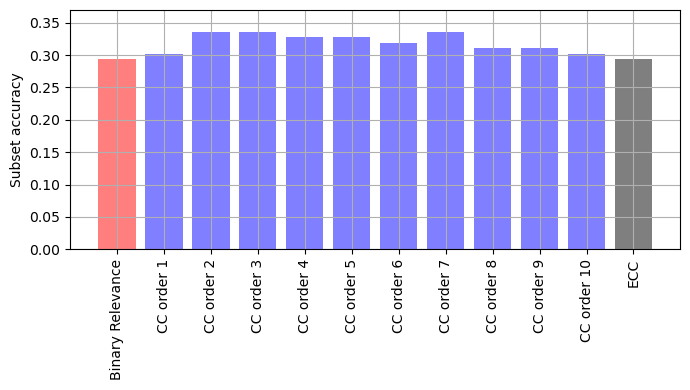

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import ClassifierChain

# DATASET:
X, Y = fetch_openml("emotions", version=4, return_X_y=True)
Y = Y == "TRUE"
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# BINARY RELEVANCE METHOD:
base_lr = make_pipeline(StandardScaler(), LogisticRegression(solver="saga", max_iter=1000))
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
#ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average="samples")
ovr_accuracy_score = accuracy_score(Y_test, Y_pred_ovr)
print(ovr_accuracy_score)

# CLASSIFIER CHAIN METHOD:
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict_proba(X_test) for chain in chains])
chain_accuracy_scores = [
    accuracy_score(Y_test, Y_pred_chain >= 0.5)
    for Y_pred_chain in Y_pred_chains
]

# ECC METHOD:
Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_accuracy_score = accuracy_score(
    Y_test, Y_pred_ensemble >= 0.5
)


#PLOT Subset Accuracy:
    
model_scores = [ovr_accuracy_score] + chain_accuracy_scores + [ensemble_accuracy_score]

model_names = (
    "Binary Relevance",
    "CC order 1",
    "CC order 2",
    "CC order 3",
    "CC order 4",
    "CC order 5",
    "CC order 6",
    "CC order 7",
    "CC order 8",
    "CC order 9",
    "CC order 10",
    "ECC",
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Subset accuracy")
ax.set_ylim([0,max(model_scores)*1.1])
colors = ["red"] + ["blue"] * len(chain_accuracy_scores) + ["black"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

# MARS

In [ ]:
#!pip install sklearn-contrib-py-earth

In [ ]:
from pyearth import Earth
model = Earth()
model.fit(X, Y)

X = np.random.normal(0, 1, (1000, 50))
epsilon = np.random.normal(0, 0.1, 1000)
Y = (X[:, 0] < 0).astype(int)  # I(X1 < 0)

plt.scatter(X[:, 0], Y, alpha=0.4, label="True")
plt.scatter(X[:, 0], model.predict(X), alpha=0.4, label="MARS prediction")
plt.legend()
plt.title("X1 vs Y + MARS")

# Semi Supervised learning

In [60]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

# Generate data
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                          n_redundant=0, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                  stratify=y, random_state=42)

# Semi-supervised setup
g = 10  # labeled examples per class
rng = np.random.default_rng(42)
y_train_semi = np.full_like(y_train, -1)  # All unlabeled initially

# Select labeled examples (stratified)
for class_label in np.unique(y_train):
    class_indices = np.where(y_train == class_label)[0]
    labeled_indices = rng.choice(class_indices, size=g, replace=False)
    y_train_semi[labeled_indices] = y_train[labeled_indices]

# Verify
print(f"Label distribution in semi-supervised set: {np.unique(y_train_semi, return_counts=True)}")
print(f"Number of labeled samples: {(y_train_semi != -1).sum()}/{len(y_train_semi)}")

Label distribution in semi-supervised set: (array([-1,  0,  1]), array([680,  10,  10]))
Number of labeled samples: 20/700


# comparison of methods

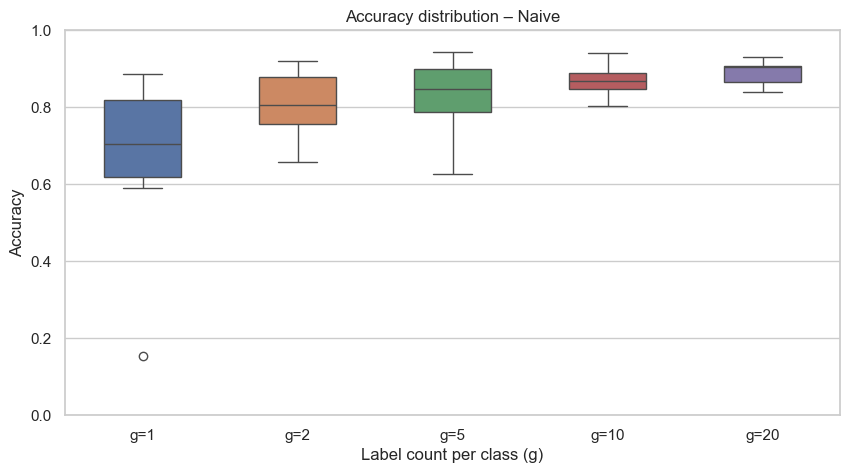

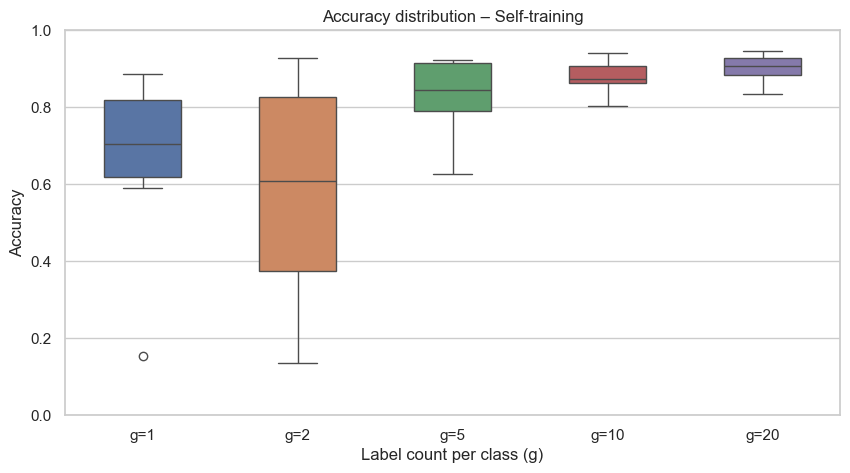

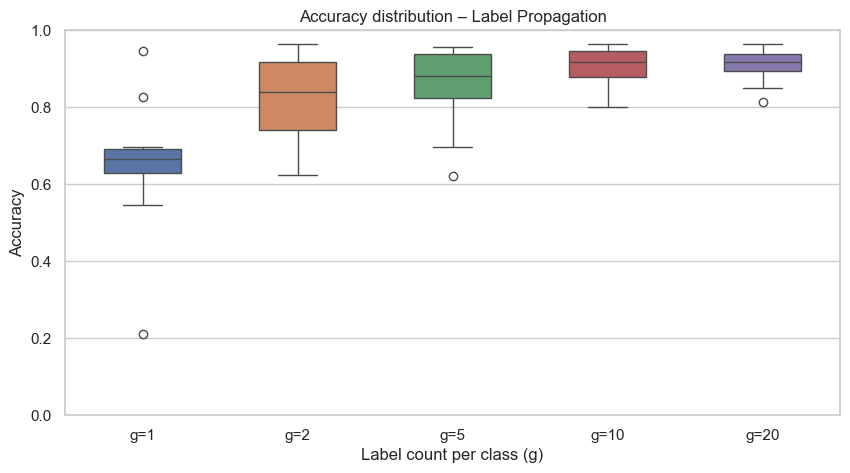

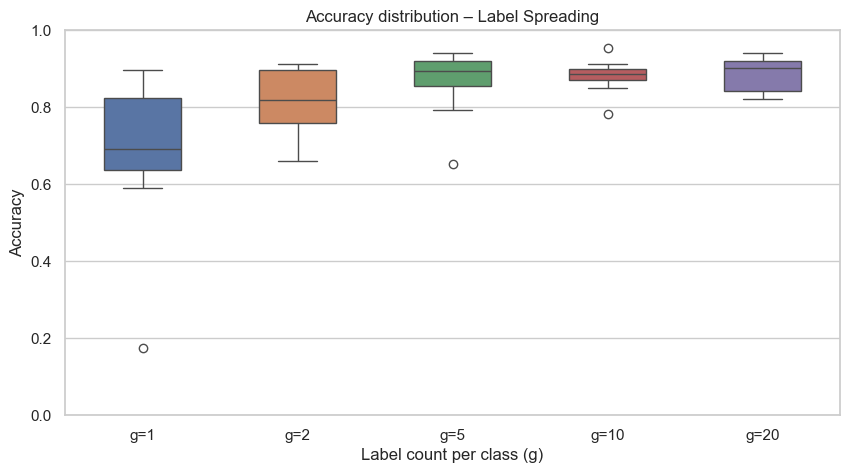

In [69]:
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Config
G_VALUES = [1, 2, 5, 10, 20]
N_REPEATS = 10
RANDOM_STATE = 42
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Init results
results = {method: {g: [] for g in G_VALUES} for method in ["Naive", "Self-training", "Label Propagation", "Label Spreading"]}

# Repeat experiments
for g in G_VALUES:
    for repeat in range(N_REPEATS):
        # 1. Generate data
        X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=repeat)
        X_train, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=repeat)

        # 2. Prepare semi-supervised labels
        y_train_semi = np.full_like(y_train_full, fill_value=-1) #Tworzy nowy wektor etykiet y_train_semi, w którym wszystkie wartości są początkowo ustawione na -1.
        for cls in [0, 1]:
            idx_cls = np.where(y_train_full == cls)[0]
            np.random.shuffle(idx_cls)
            y_train_semi[idx_cls[:g]] = y_train_full[idx_cls[:g]]

        # 3. Naive – tylko oznakowane
        mask_labeled = y_train_semi != -1
        naive_clf = SVC(probability=True, max_iter=1000)
        naive_clf.fit(X_train[mask_labeled], y_train_semi[mask_labeled])
        acc = accuracy_score(y_test, naive_clf.predict(X_test))
        results["Naive"][g].append(acc)

        # 4. Self-training
        self_training = SelfTrainingClassifier(SVC(probability=True, max_iter=1000))
        self_training.fit(X_train, y_train_semi)
        acc = accuracy_score(y_test, self_training.predict(X_test))
        results["Self-training"][g].append(acc)

        # 5. Label Propagation
        lp = LabelPropagation(max_iter=1000)
        lp.fit(X_train, y_train_semi)
        acc = accuracy_score(y_test, lp.predict(X_test))
        results["Label Propagation"][g].append(acc)

        # 6. Label Spreading
        ls = LabelSpreading()
        ls.fit(X_train, y_train_semi)
        acc = accuracy_score(y_test, ls.predict(X_test))
        results["Label Spreading"][g].append(acc)

# Plot
sns.set(style="whitegrid")

for method in results:
    plt.figure(figsize=(10, 5))
    data = [results[method][g] for g in G_VALUES]
    sns.boxplot(data=data, width=0.5)
    plt.xticks(ticks=range(len(G_VALUES)), labels=[f"g={g}" for g in G_VALUES])
    plt.title(f"Accuracy distribution – {method}")
    plt.ylabel("Accuracy")
    plt.xlabel("Label count per class (g)")
    plt.ylim(0, 1)
    plt.show()

